# Credit Risk
## Improving business with a credit risk model

These are the packages that I imported. I separated them by their purpose.

In [1]:
# data manipulation
import pickle
import pandas as pd
import numpy as np

# EDA
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from scipy.stats import chi2_contingency
from pyitlib import discrete_random_variable as drv

# data preprocessing
from sklearn.preprocessing import MinMaxScaler

# feature selection
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy

# machine learning
from sklearn.model_selection import train_test_split
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline
from scipy import stats

# algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from catboost import CatBoostClassifier

# model evaluation
from sklearn.metrics import classification_report, precision_recall_fscore_support, f1_score
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score
from sklearn.metrics import confusion_matrix, precision_recall_curve, brier_score_loss
from sklearn.model_selection import StratifiedKFold, cross_val_score

# hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV

# model calibration
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

# Checking the data set

## Data Dictionary

| Column                         | Description                                                                                                    |
|:--------------------------------|:----------------------------------------------------------------------------------------------------------------|
| person\_age                    | The person's age in years                                                                                      |
| person\_income                 | The person's anual income                                                                                      |
| person\_home\_ownership        | The type of home ownership \(RENT; OWN; MORTGAGE; OTHER\)                                                      |
| person\_emp\_length            | The person's employment length in years                                                                        |
| loan\_intent                   | The person's intent for the loan \(PERSONAL, EDUCATION, MEDICAL, VENTURE, HOMEIMPROVEMENT, DEBTCONSOLIDATION\) |
| loan\_grade                    | The loan grade \(A, B, C, D, E, F, G\)                                                                         |
| loan\_amnt                     | The loan amount                                                                                                |
| loan\_int\_rate                | The loan interest rate                                                                                         |
| loan\_status                   | Shows whether the loan is currently in default with 1 being default and 0 being non\-default                   |
| loan\_percent\_income          | The percentage of person's income dedicated for the mortgage                                                   |
| cb\_person\_default\_on\_file  | If the person has a default history \(Yes; No\)                                                                |
| cb\_person\_cred\_hist\_length | The person's credit history                                                                                    |


## Loading the data set

In [3]:
# loads data set
df_cr_loan = pd.read_csv('/Users/aaryamehta/Desktop/CAPSTONE/credit_risk-master/data/raw_cr_loan2.csv')

# checks the first five rows of the data
df_cr_loan.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [4]:
# checks the structure of the data set
df_cr_loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


## Descriptive statistics

In [5]:
# creates a dataset for numerical attributes
num_attributes = df_cr_loan.select_dtypes(include=['int64', 'float64'])

# creates a dataset for categorical attributes
cat_attributes = df_cr_loan.select_dtypes(exclude=['int64', 'float64'])

In [6]:
# checks the operation
num_attributes.sample(2)

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
6629,26,51356,4.0,6000,5.79,0,0.12,4
3330,24,40000,1.0,3600,13.49,0,0.09,3


In [7]:
# checks the operation
cat_attributes.sample(2)

,person_home_ownership,loan_intent,loan_grade,cb_person_default_on_file
9485,MORTGAGE,MEDICAL,E,Y
19052,RENT,PERSONAL,A,N


In [8]:
# central tendency: mean, median
mean = pd.DataFrame(num_attributes.apply(np.mean)).T
median = pd.DataFrame(num_attributes.apply(np.median)).T

# distribution: std, min, max, range, skew, kurtosis
std = pd.DataFrame(num_attributes.apply(np.std)).T
min_value = pd.DataFrame(num_attributes.apply(min)).T
max_value = pd.DataFrame(num_attributes.apply(max)).T
range_value = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
skewness = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
kurtosis = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# concatenates
summary_stats = pd.concat([min_value, max_value, range_value, mean, median, std, skewness, kurtosis]).T.reset_index()
summary_stats.columns = ['attributes','min','max','range','mean','median','std','skewness','kurtosis']

In [9]:
# checks the operations
summary_stats

,attributes,min,max,range,mean,median,std,skewness,kurtosis
0,person_age,20.00,144.00,124.00,27.734600,26.00,6.347981,2.581393,18.560825
1,person_income,4000.00,6000000.00,5996000.00,66074.848470,55000.00,61982.167945,32.865349,2693.272776
2,person_emp_length,0.00,123.00,123.00,4.789686,NaN,4.142565,2.614455,43.722338
3,loan_amnt,500.00,35000.00,34500.00,9589.371106,8000.00,6321.989624,1.192477,1.423565
4,loan_int_rate,5.42,23.22,17.80,11.011695,NaN,3.240404,0.208550,-0.671609
5,loan_status,0.00,1.00,1.00,0.218164,0.00,0.412999,1.364888,-0.137088
6,loan_percent_income,0.00,0.83,0.83,0.170203,0.15,0.106780,1.064669,1.223687
7,cb_person_cred_hist_length,2.00,30.00,28.00,5.804211,4.00,4.054939,1.661790,3.716194


As observed, we can notice the presence of outliers in `person_age` (`max = 144`) and `person_emp_length` (`max = 123`).

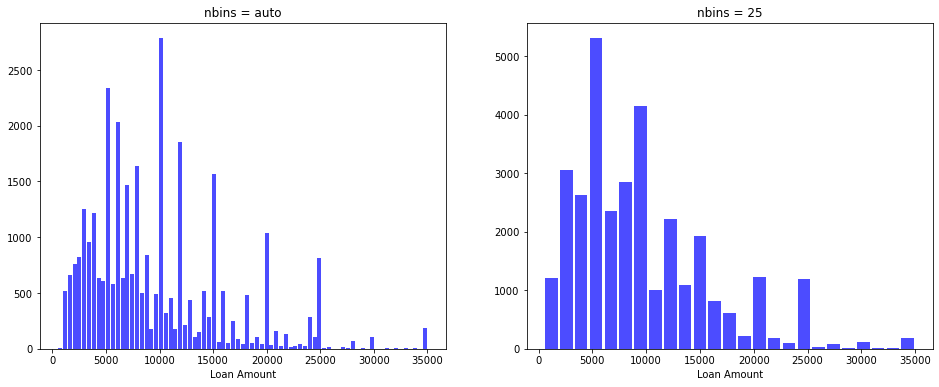

In [10]:
# looks at the distribution of loan amounts with a histogram
plt.figure(figsize=(16, 6))

plt.subplot(1,2,1)
n, bins, patches = plt.hist(x=df_cr_loan['loan_amnt'], bins='auto', color='blue', alpha=0.7, rwidth=0.85)
plt.title("nbins = auto")
plt.xlabel("Loan Amount")

plt.subplot(1,2,2)
n, bins, patches = plt.hist(x=df_cr_loan['loan_amnt'], bins=25, color='blue', alpha=0.7, rwidth=0.85)
plt.title("nbins = 25")
plt.xlabel("Loan Amount")

plt.show()

### Categorical attributes

In [11]:
# checks how many types we have for each atribute
cat_attributes.apply(lambda x: x.unique().shape[0])

person_home_ownership        4
loan_intent                  6
loan_grade                   7
cb_person_default_on_file    2
dtype: int64

### Crosstab and pivot tables

In [12]:
# creates a cross table of the loan intent and loan status
pd.crosstab(df_cr_loan['loan_intent'], df_cr_loan['loan_status'], margins=True)

loan_status,0,1,All
loan_intent,,,
DEBTCONSOLIDATION,3722,1490,5212
EDUCATION,5342,1111,6453
HOMEIMPROVEMENT,2664,941,3605
MEDICAL,4450,1621,6071
PERSONAL,4423,1098,5521
VENTURE,4872,847,5719
All,25473,7108,32581


As observed: 
- `VENTURE` has the least number of defaults while `MEDICAL` has the most.
- `EDUCATION` and `MEDICAL` are the greatest loan intents while `HOMEIMPROVEMENT` is the least.
- `MEDICAL` and `DEBTCONSOLIDATION` are the intents where there are more defaults.

In [13]:
# creates a cross table of home ownership, loan status, and grade
pd.crosstab(df_cr_loan['person_home_ownership'], [df_cr_loan['loan_status'], df_cr_loan['loan_grade']], 
            margins=True)

loan_status               0                                   1              \
loan_grade                A     B     C     D    E   F  G     A     B     C   
person_home_ownership                                                         
MORTGAGE               5219  3729  1934   658  178  36  0   239   324   321   
OTHER                    23    29    11     9    2   0  0     3     5     6   
OWN                     860   770   464   264   26   7  0    66    34    31   
RENT                   3602  4222  2710   554  137  28  1   765  1338   981   
All                    9704  8750  5119  1485  343  71  1  1073  1701  1339   

loan_status                                  All  
loan_grade                D    E    F   G         
person_home_ownership                             
MORTGAGE                553  161   61  31  13444  
OTHER                    11    6    2   0    107  
OWN                      18   31    8   5   2584  
RENT                   1559  423   99  27  16446  
All                    2141  621  170  63  32581

In [14]:
# creates a cross table of home ownership, loan status, and average percent income
pd.crosstab(df_cr_loan['person_home_ownership'], df_cr_loan['loan_status'],
              values=df_cr_loan['loan_percent_income'], aggfunc='mean')

loan_status,0,1
person_home_ownership,,
MORTGAGE,0.146504,0.184882
OTHER,0.143784,0.300000
OWN,0.180013,0.297358
RENT,0.144611,0.264859


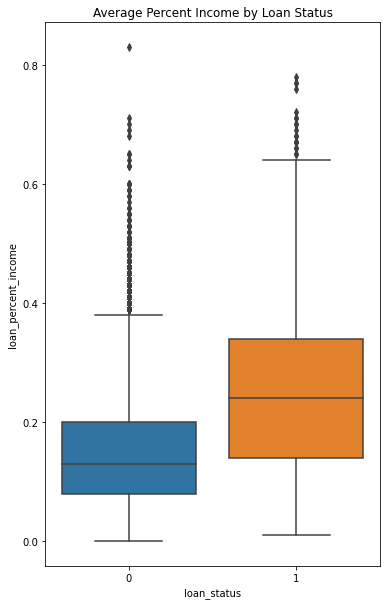

In [15]:
# creates a box plot of percentage income by loan status
plt.figure(figsize=(6, 10))

plt.title('Average Percent Income by Loan Status')
plt.suptitle('')

sns.boxplot(x='loan_status' , y='loan_percent_income', data=df_cr_loan)

plt.show()

 It looks like the **average percentage of income for defaults is higher**. This could indicate those recipients have a debt-to-income ratio that's already too high.

## Checking outliers

### By scatterplot

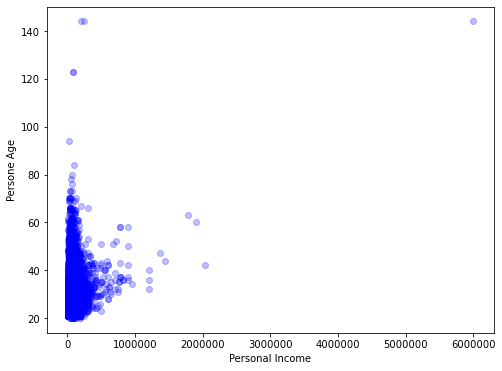

In [16]:
# plots a scatter plot of income against age
plt.figure(figsize=(8, 6))

plt.scatter(df_cr_loan['person_income'], df_cr_loan['person_age'], color='blue', alpha=0.25)
plt.xlabel('Personal Income')
plt.ylabel('Persone Age')

# prevents scientific notation on axis
plt.ticklabel_format(useOffset=False, style='plain')

plt.show()

We can already see a positive correlation with age and income, which could mean these older recipients are further along in their career and therefore earn higher salaries. There also appears to have outliers in the data.

### Finding outliers with cross tables

Now we need to find and remove outliers we suspect might be in the data. We can use cross tables and aggregate functions. Have a look at the `person_emp_length` column. To detect outliers we can use functions like `min` and `max`.

In [17]:
# creates the cross table for loan status, home ownership, and the max employment length
pd.crosstab(df_cr_loan['loan_status'],df_cr_loan['person_home_ownership'],
        values=df_cr_loan['person_emp_length'], aggfunc='max')

person_home_ownership,MORTGAGE,OTHER,OWN,RENT
loan_status,,,,
0,123.0,24.0,31.0,41.0
1,34.0,11.0,17.0,123.0


It may not be possible for a person to have an employment length of less than `0` or greater than `60`. We can use cross tables to check the data and see if there are any instances of this!

In [18]:
# creates an array of indices where employment length is greater than 60
indices = df_cr_loan[df_cr_loan['person_emp_length'] > 60].index
indices

Int64Index([0, 210], dtype='int64')

In [19]:
# checks how many records presents employment length greater than 60
len(indices)

2

In [20]:
# checks which records will be dropped
df_cr_loan.loc[[0, 210]]

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
210,21,192000,MORTGAGE,123.0,VENTURE,A,20000,6.54,0,0.10,N,4


In [21]:
# drops the records from the data based on the indices and create a new dataframe
df_cr_loan_new = df_cr_loan.drop(indices)

Generally with credit data, key columns like `person_emp_length` are of high quality, but there is always room for error. With this in mind, we build our intuition for detecting outliers!

### Visualizing credit outliers

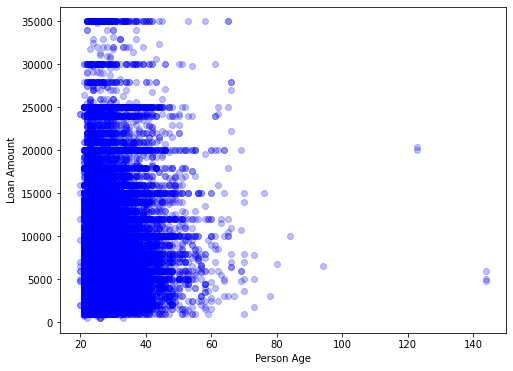

In [22]:
# creates the scatter plot for age and amount
plt.figure(figsize=(8, 6))
plt.scatter(df_cr_loan_new['person_age'], df_cr_loan_new['loan_amnt'], color='blue', alpha=0.25)
plt.xlabel("Person Age")
plt.ylabel("Loan Amount")
plt.show()

In [23]:
# uses pandas to drop the record from the data frame and create a new one
df_cr_loan_new = df_cr_loan_new.drop(df_cr_loan_new[df_cr_loan_new['person_age'] > 100].index)

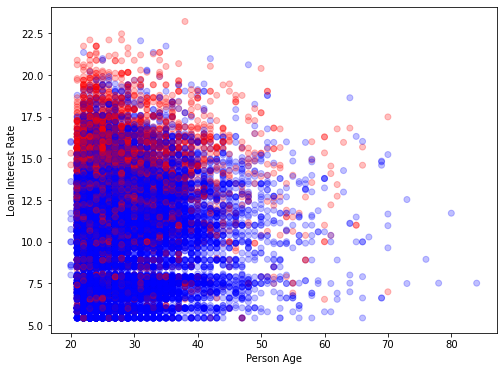

In [24]:
# creates a scatter plot of age and interest rate
colors = ["blue","red"]
plt.figure(figsize=(8, 6))
plt.scatter(df_cr_loan_new['person_age'], df_cr_loan_new['loan_int_rate'],
            c = df_cr_loan_new['loan_status'],
            cmap = matplotlib.colors.ListedColormap(colors),
            alpha=0.25)
plt.xlabel("Person Age")
plt.ylabel("Loan Interest Rate")
plt.show()

Notice that in the last plot we have `loan_status` as a label for colors. This shows a different color depending on the class. In this case, it's loan default and non-default, and **it looks like there are more defaults with high interest rates**.

## Checking missing data

### Replacing missing credit data

In [25]:
# overwrites the raw data set
df_cr_loan = df_cr_loan_new.copy()

In [26]:
# prints the cols that contain null values
df_cr_loan.columns[df_cr_loan.isnull().any()]

Index(['person_emp_length', 'loan_int_rate'], dtype='object')

In [27]:
# checks how many null records for each column 
df_cr_loan.isnull().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3115
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

In [28]:
# prints the top five rows with nulls for employment length
df_cr_loan[df_cr_loan['person_emp_length'].isnull()].head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
105,22,12600,MORTGAGE,NaN,PERSONAL,A,2000,5.42,1,0.16,N,4
222,24,185000,MORTGAGE,NaN,EDUCATION,B,35000,12.42,0,0.19,N,2
379,24,16800,MORTGAGE,NaN,DEBTCONSOLIDATION,A,3900,NaN,1,0.23,N,3
407,25,52000,RENT,NaN,PERSONAL,B,24000,10.74,1,0.46,N,2
408,22,17352,MORTGAGE,NaN,EDUCATION,C,2250,15.27,0,0.13,Y,3


We can use several different functions like `mean()` and `median()` to replace missing data. The goal here is to keep as much of our data as we can! It's also important to check the distribution of that feature to see if it changed.

In [29]:
# imputes the null values with the median value for all employment lengths
df_cr_loan['person_emp_length'].fillna((df_cr_loan['person_emp_length'].median()), inplace=True)

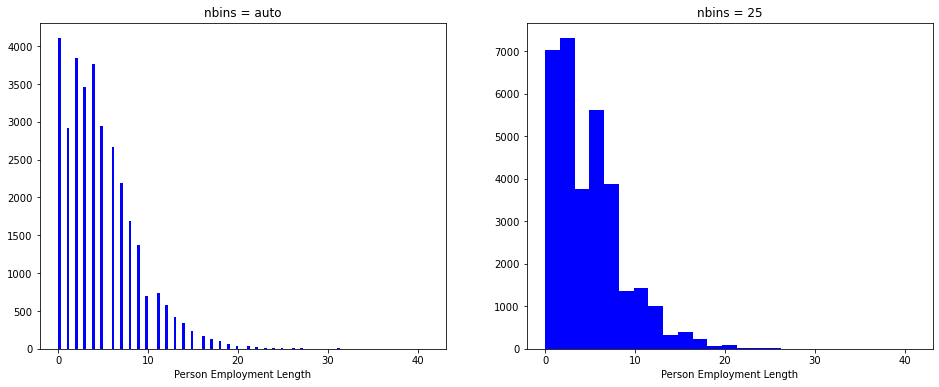

In [30]:
# creates a histogram of employment length
plt.figure(figsize=(16, 6))

plt.subplot(1,2,1)
n, bins, patches = plt.hist(df_cr_loan['person_emp_length'], bins='auto', color='blue')
plt.xlabel("Person Employment Length")
plt.title("nbins = auto")

plt.subplot(1,2,2)
n, bins, patches = plt.hist(df_cr_loan['person_emp_length'], bins=25, color='blue')
plt.xlabel("Person Employment Length")
plt.title("nbins = 25")

plt.show()

### Removing missing data

In [31]:
# prints the number of nulls
print(df_cr_loan['loan_int_rate'].isnull().sum())

3115


In [32]:
# stores the array on indices
indices = df_cr_loan[df_cr_loan['loan_int_rate'].isnull()].index

# saves the new data without missing data
df_cr_loan_clean = df_cr_loan.drop(indices)

### Missing data intuition

In [33]:
# counts the number of records for each unique value
df_cr_loan_clean['person_home_ownership'].value_counts()

RENT        14890
MORTGAGE    12119
OWN          2356
OTHER          94
Name: person_home_ownership, dtype: int64

In [34]:
# checks the cleaned data set
df_cr_loan_clean.isna().sum()

person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_status                   0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
dtype: int64

## Checkpoint

In [36]:
# saves the data set state
df_cr_loan_clean.to_csv('/Users/aaryamehta/Desktop/CAPSTONE/credit_risk-master/data/cr_loan_clean.csv', index=False)

# Outlining the hypotheses

## Creating hypotheses

### 1 Person Age

1. There are more defaults for young people.

### 2 Person Income

1. People who default have lower income than people who not default.
2. People who allocate higher percentage of income to the loan tend to default more than people who allocate less.

### 3 Home ownership

1. Mortgage have more cases of default, followed by rent and own.

### 4 Employment Length

1. The are fewer cases of default for people with long employment length.

### 5 Default on file

1. There are more cases of default for people having history of default.

### 6 Credit history length

1. There are fewer cases of default for people having longer credit history length.

### 7 Loan intent

1. There are more cases of default for personal, followed by education, medical, home improvement and debt consolidation.
2. The least cases of default are for venture.

### 8 Loan grade

1. The higher the grade, the fewer are the cases of default.

### 9 Loan amount

1. The amount median for default cases is higher than for non-default.

### 10 Loan interest rate

1. The higher the interest rate, the higher is the number of default cases.

#  Exploratory data analysis

##  Loading data set

In [37]:
# loads data set
df_cr_loan = pd.read_csv('data/cr_loan_clean.csv')
df_cr_loan.head()

FileNotFoundError: [Errno 2] No such file or directory: 'data/cr_loan_clean.csv'

In [38]:
# checks the size
df_cr_loan.shape

(32574, 12)

## Univariate analysis

### Target variable

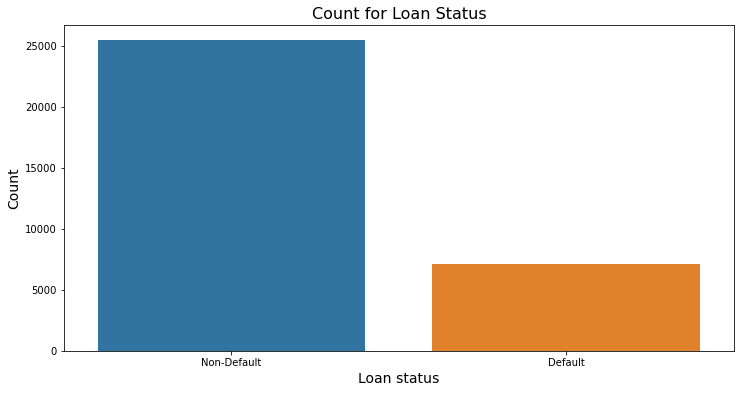

In [39]:
# plots count
ax = sns.countplot(x=df_cr_loan['loan_status'])

# sets the figure size in inches
ax.figure.set_size_inches(12, 6)

# set plot features
ax.set_title("Count for Loan Status", fontsize=16)
ax.set_ylabel("Count", fontsize=14)
ax.set_xlabel("Loan status", fontsize=14)

# set xticks labels
plt.xticks([0, 1], ['Non-Default', 'Default'])

# displays plot
plt.show()

In [40]:
# separating the data set for easier analysis
df_default = df_cr_loan[df_cr_loan['loan_status'] == 1].copy()
df_non_default = df_cr_loan[df_cr_loan['loan_status'] == 0].copy()

In [41]:
# counts the number of defaults and non-defaults
total_default = df_default.shape[0]
total_non_default = df_non_default.shape[0]
total_loans = df_cr_loan.shape[0]

print('Number of default cases:', total_default)
print('This is equivalent to {:.2f}% of the total loans'.format((total_default/total_loans)*100))

print('\nNumber of non-defualt cases:', total_non_default)
print('This is equivalent to {:.2f}% of the total loans'.format((total_non_default/total_loans)*100))

Number of default cases: 7107
This is equivalent to 21.82% of the total loans

Number of non-defualt cases: 25467
This is equivalent to 78.18% of the total loans


As observed, there are many more cases of non-default. Thus, we're dealing with an imbalanced data set. We're going to handle this later in section 7 of this notebook.

###  Numerical variables

In [42]:
# creates a dataset for numerical attributes
num_attributes = df_cr_loan.select_dtypes(include=['int64', 'float64'])

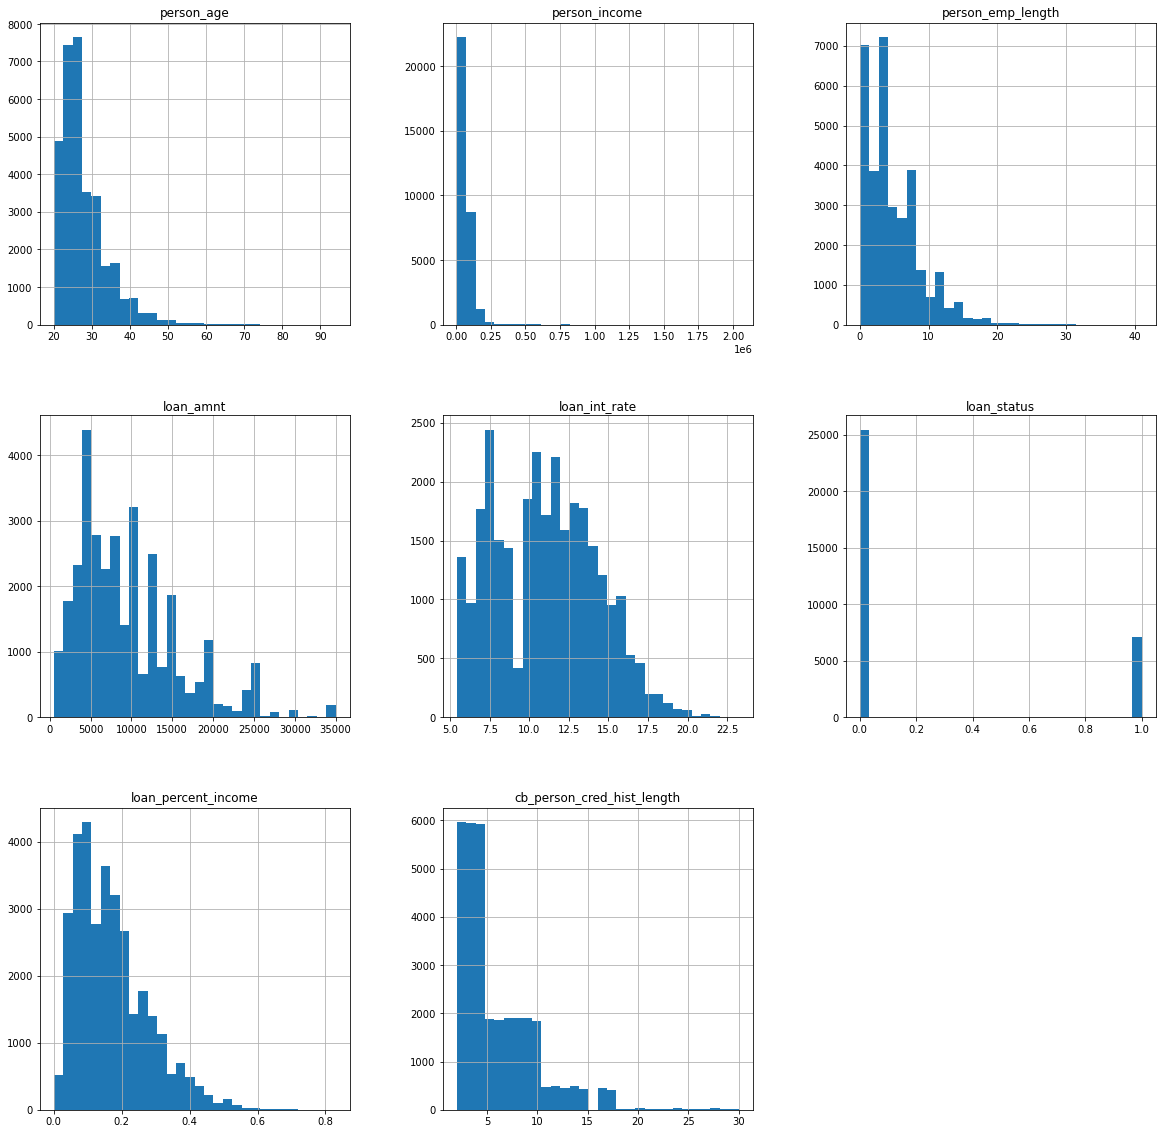

In [43]:
# plots a histogram for all numerical attributes
_ = num_attributes.hist(bins=30, figsize=(20,20))

As we can observe, there is no variable that presents a normal distribution. Note that here, we're only exploring the data, not making any handling or transformation.

###  Categorical variables

In [44]:
# creates a dataset for categorical attributes
cat_attributes = df_cr_loan.select_dtypes(exclude=['int64', 'float64'])

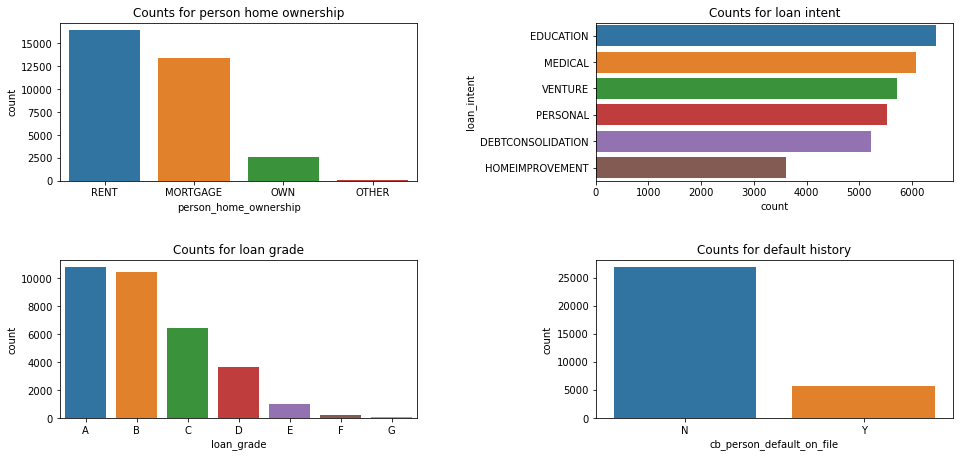

In [45]:
# uses the variable ax for a single Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(16, 16)

# person_home_ownership
plt.subplot(4, 2, 1)
sns.countplot(x=cat_attributes['person_home_ownership'], 
              order=cat_attributes['person_home_ownership'].value_counts().index)
plt.title("Counts for person home ownership")

# loan_intent
plt.subplot(4, 2, 2)
sns.countplot(y=cat_attributes['loan_intent'], 
              order=cat_attributes['loan_intent'].value_counts().index)
plt.title("Counts for loan intent")

# loan_grade
plt.subplot(4, 2, 3)
sns.countplot(x=cat_attributes['loan_grade'], 
              order=cat_attributes['loan_grade'].value_counts().index)
plt.title("Counts for loan grade")

# cb_person_default_on_file
plt.subplot(4, 2, 4)
sns.countplot(x=cat_attributes['cb_person_default_on_file'], 
              order=cat_attributes['cb_person_default_on_file'].value_counts().index)
plt.title("Counts for default history")

# adjusts vertical space between plots
plt.subplots_adjust(hspace = 0.5)
plt.subplots_adjust(wspace = 0.5)

# display plots
plt.show()

##  Bivariate analysis - Hypotheses validation

### H1. There are more defaults for young people. <font color='green'>(TRUE)

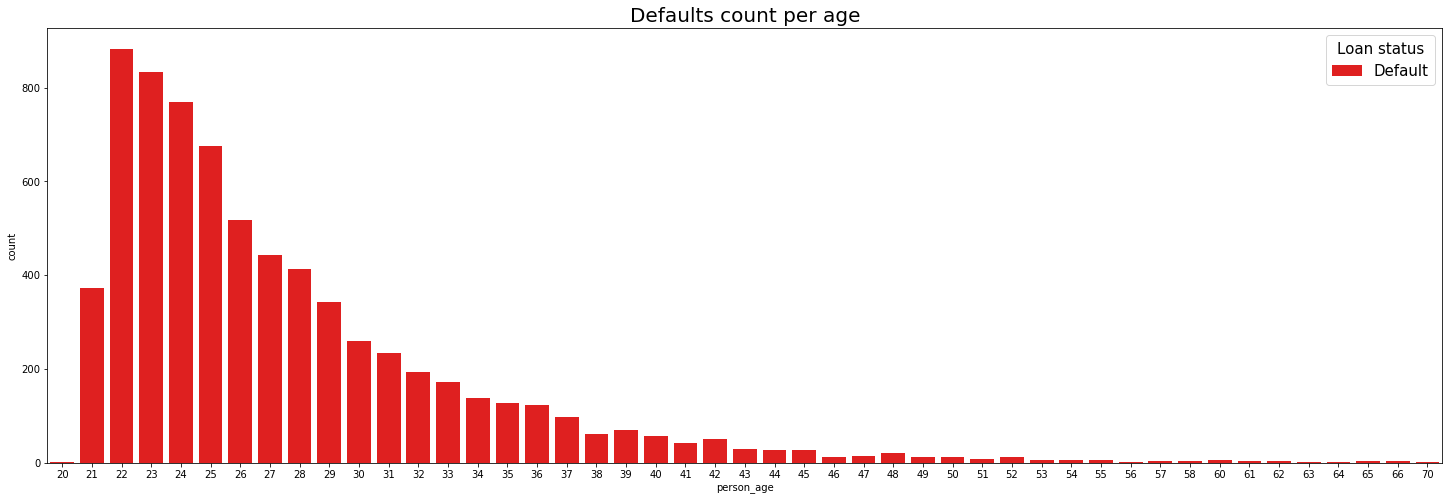

In [46]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(25, 8)

# plots the graph
sns.countplot(x='person_age', hue='loan_status', data=df_default, palette=["r"])

# sets plot title
ax.set_title("Defaults count per age", fontsize=20)

# sets the legend
plt.legend(title="Loan status", labels=['Default'], title_fontsize=15, fontsize=15)

# display plots
plt.show()

As observed, there are more deault cases for people at young age (up to 40s).

> Thus, the hypothesis is **TRUE**.

### H2. People who default have lower income than people who not default. <font color='green'>(TRUE)

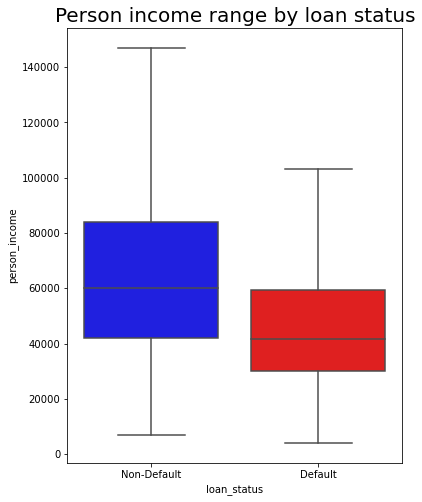

In [47]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(6, 8)

# plots the graph
sns.boxplot(x='loan_status', y='person_income',  data=df_cr_loan, showfliers=False, palette=["b", "r"])

# sets plot title
ax.set_title("Person income range by loan status", fontsize=20)

# set xticks labels
plt.xticks([0, 1], ['Non-Default', 'Default'])

# display plots
plt.show()

As observed, the mean income for people who default is lower than for people who don't.

> Thus, the hypothesis is **TRUE**.

### H3. The median percentage of income to the loan is higher for default than the median for non-default. <font color='green'>(TRUE)

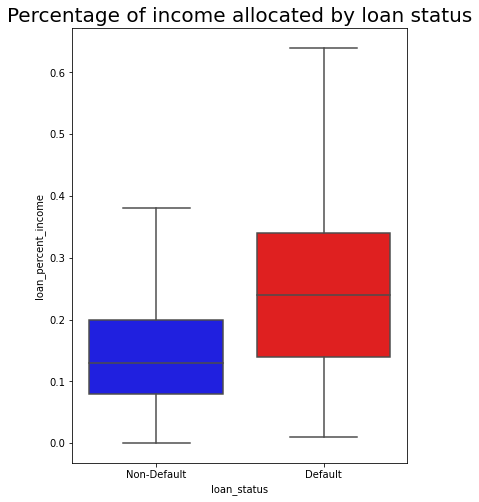

In [48]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(6, 8)

# plots the graph
sns.boxplot(x='loan_status', y='loan_percent_income',  data=df_cr_loan, 
            showfliers=False, palette=["b", "r"])

# sets plot title
ax.set_title("Percentage of income allocated by loan status", fontsize=20)

# set xticks labels
plt.xticks([0, 1], ['Non-Default', 'Default'])

# display plots
plt.show()

As observed, the median of the percentage of income allocated is higher for people who default than for the people who don't.

> Thus, the hypothesis is **TRUE**.

### H4. Mortgage have more cases of default, followed by rent and own. <font color='red'>(FALSE)

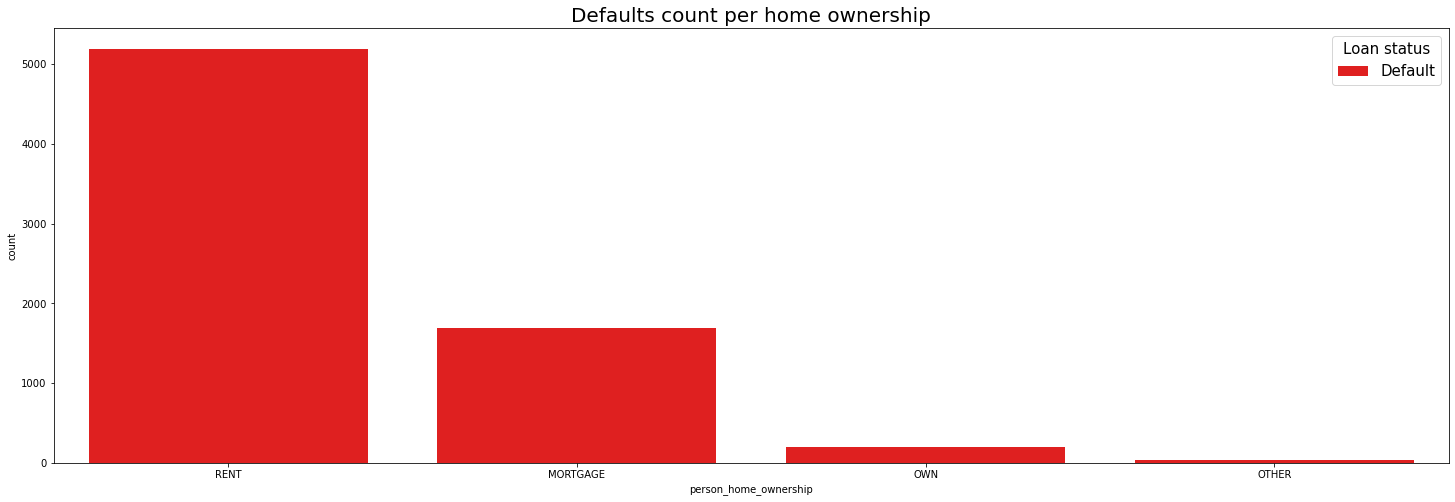

In [49]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(25, 8)

# plots the graph
sns.countplot(x='person_home_ownership', hue='loan_status', data=df_default, 
              order=df_default['person_home_ownership'].value_counts().index, palette=["r"])

# sets plot title
ax.set_title("Defaults count per home ownership", fontsize=20)

# sets the legend
plt.legend(title="Loan status", labels=['Default'], title_fontsize=15, fontsize=15)

# display plots
plt.show()

As observed, `RENT` is the top home ownership type for people who default, not `MORTGAGE`.

> Thus, the hypothesis is **FALSE**.

### H5. The are fewer cases of default for people with long employment length. <font color='green'>(TRUE)

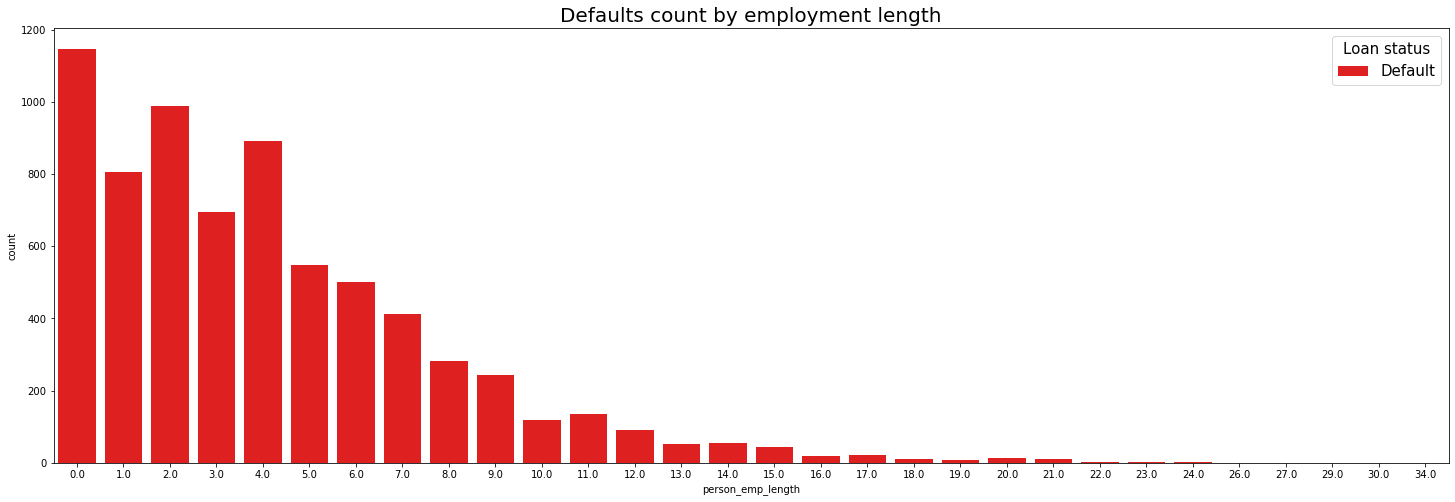

In [50]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(25, 8)

# plots the graph
sns.countplot(x='person_emp_length', hue='loan_status', data=df_default, palette=["r"])

# sets plot title
ax.set_title("Defaults count by employment length", fontsize=20)

# sets the legend
plt.legend(title="Loan status", labels=['Default'], title_fontsize=15, fontsize=15)

# display plots
plt.show()

As observed, the are fewer cases of default for people with long employment length that for people in the early years.

> Thus, the hypothesis is **TRUE**.

### H6. There are more cases of default for people having history of default. <font color='red'>(FALSE)

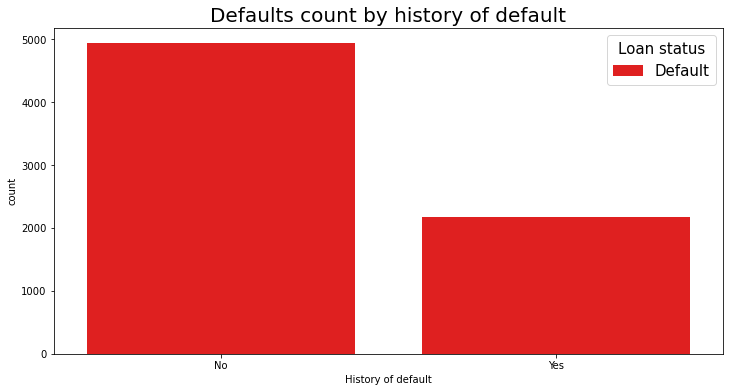

In [51]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(12, 6)

# plots the graph
sns.countplot(x='cb_person_default_on_file', hue='loan_status', data=df_default, palette=["r"])

# sets plot title
ax.set_title("Defaults count by history of default", fontsize=20)

# sets the legend
plt.legend(title="Loan status", labels=['Default'], title_fontsize=15, fontsize=15)

plt.xlabel("History of default")

# set xticks labels
plt.xticks([0, 1], ['No', 'Yes'])

# display plots
plt.show()

As observed, there are more cases of default for people who don't have history of default.

> Thus, the hypothesis is **FALSE**.

### H7. There are fewer cases of default for people having longer credit history length. <font color='green'>(TRUE)

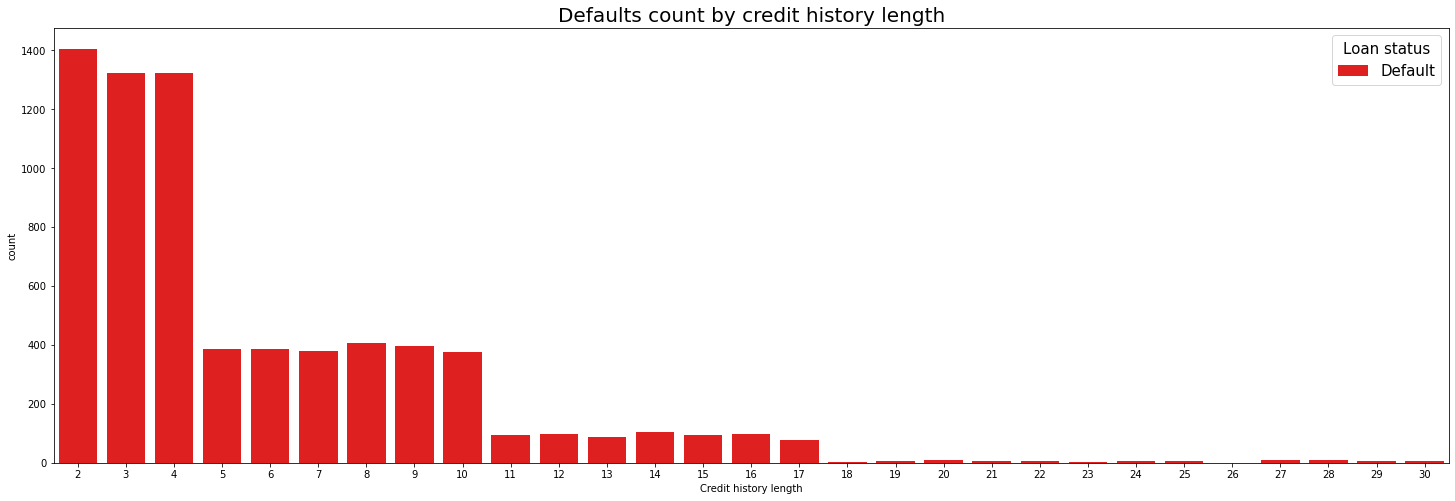

In [52]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(25, 8)

# plots the graph
sns.countplot(x='cb_person_cred_hist_length', hue='loan_status', data=df_default, palette=["r"])

# sets plot title
ax.set_title("Defaults count by credit history length", fontsize=20)

# sets the legend
plt.legend(title="Loan status", labels=['Default'], title_fontsize=15, fontsize=15)

plt.xlabel("Credit history length")

# display plots
plt.show()

As observed, there are fewer cases of default for people having longer credit history length.

> Thus, the hypothesis is **TRUE**.

### H8. There are more cases of default for personal than any other intent. <font color='red'>(FALSE)</font>
### H9. The least cases of default are for venture. <font color='green'>(TRUE)

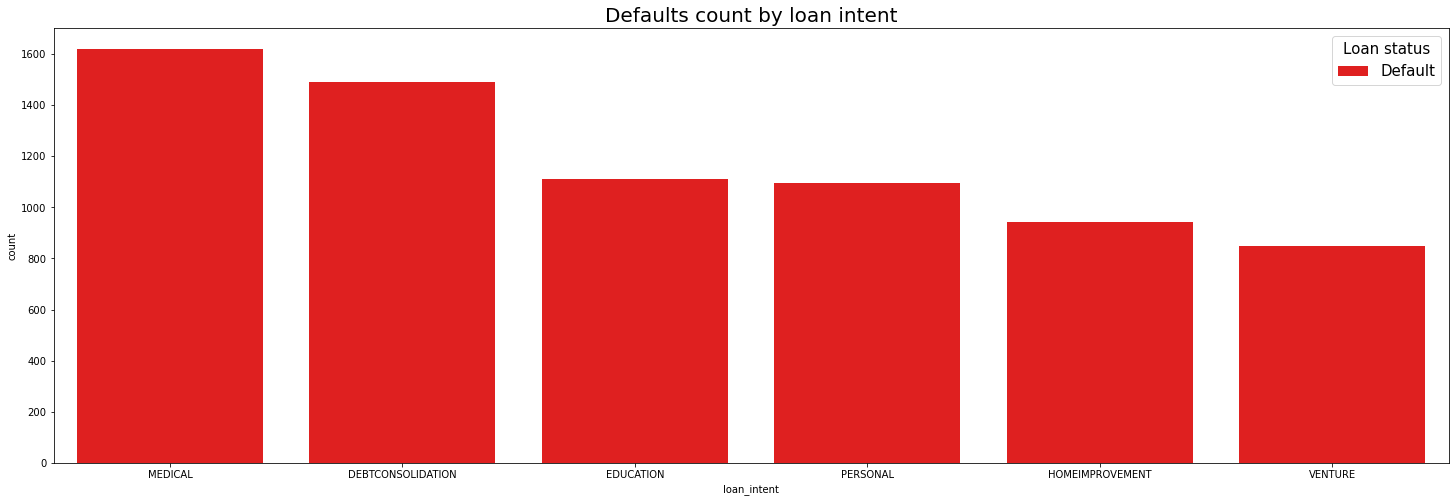

In [53]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(25, 8)

# plots the graph
sns.countplot(x='loan_intent', hue='loan_status', data=df_default, 
              order=df_default['loan_intent'].value_counts().index, palette=["r"])

# sets plot title
ax.set_title("Defaults count by loan intent", fontsize=20)

# sets the legend
plt.legend(title="Loan status", labels=['Default'], title_fontsize=15, fontsize=15)

# display plots
plt.show()

As observed, `MEDICAL` holds the most number of default cases and `VENTURE` the least.

> Thus, the hypothesis is **FALSE**.

### H10. The higher the grade, the fewer are the cases of default. <font color='red'>(FALSE)

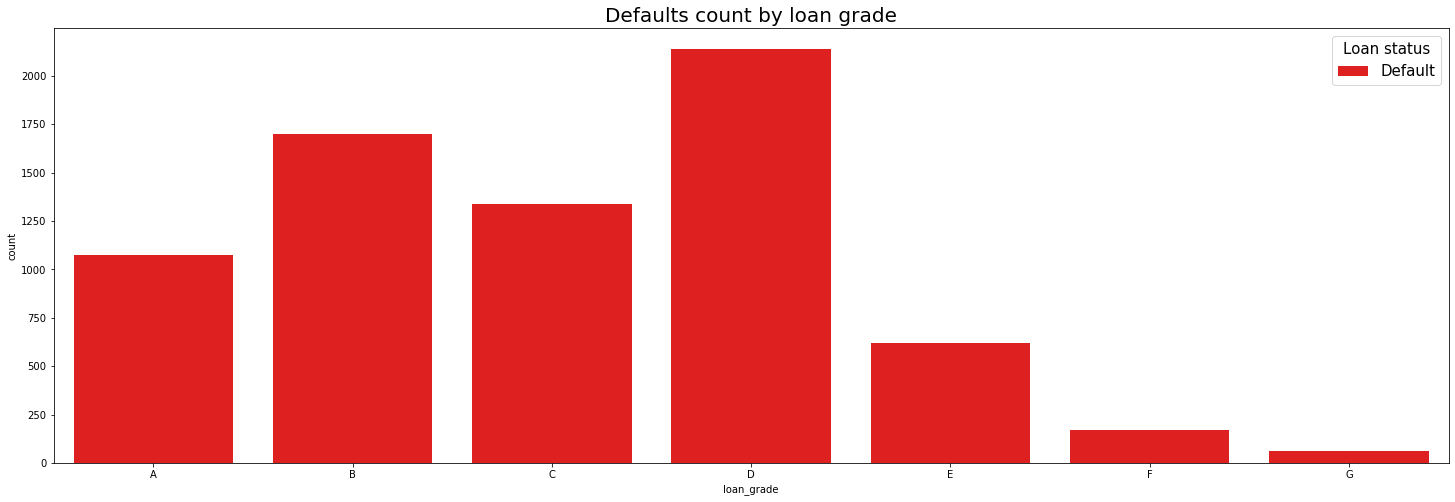

In [54]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(25, 8)

# plots the graph
sns.countplot(x='loan_grade', hue='loan_status', data=df_default, 
              order=df_default['loan_grade'].value_counts().index.sort_values(), palette=["r"])

# sets plot title
ax.set_title("Defaults count by loan grade", fontsize=20)

# sets the legend
plt.legend(title="Loan status", labels=['Default'], title_fontsize=15, fontsize=15)

# display plots
plt.show()

As observed, despite the grade `D` that is right at the middle grade, the higher the loand grade, the higher is the number of default cases.

> Thus, the hypothesis is **FALSE**.

### H11. The loan amount median for default cases is higher than for non-default. <font color='green'>(TRUE)

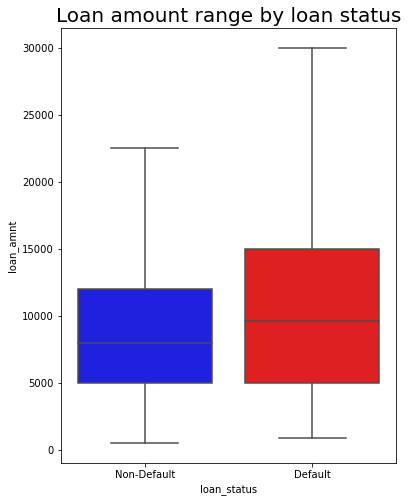

In [55]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(6, 8)

# plots the graph
sns.boxplot(x='loan_status', y='loan_amnt',  data=df_cr_loan, showfliers=False, palette=["b", "r"])

# sets plot title
ax.set_title("Loan amount range by loan status", fontsize=20)

# set xticks labels
plt.xticks([0, 1], ['Non-Default', 'Default'])

# display plots
plt.show()

As observed, the loan amount median for default cases is higher than for non-default.

> Thus, the hypothesis is **TRUE**.

### H12. The interest rate median for default cases is higher than for non-default. <font color='green'>(TRUE)

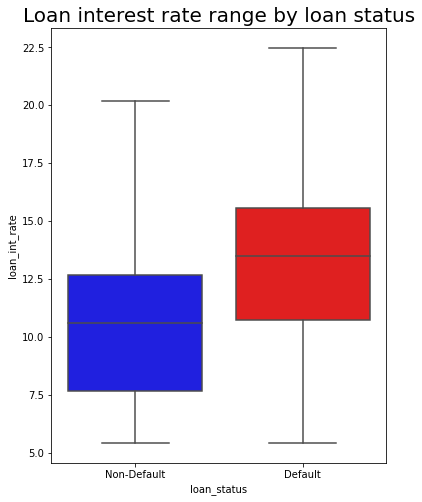

In [56]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(6, 8)

# plots the graph
sns.boxplot(x='loan_status', y='loan_int_rate',  data=df_cr_loan, showfliers=False, palette=["b", "r"])

# sets plot title
ax.set_title("Loan interest rate range by loan status", fontsize=20)

# set xticks labels
plt.xticks([0, 1], ['Non-Default', 'Default'])

# display plots
plt.show()

As observed, the interest rate median for default cases is higher than for non-default.

> Thus, the hypothesis is **TRUE**.

###  Hypotheses Summary 

| ID  | Hypothesis                                                                                         | Conclusion |
|:-----:|:----------------------------------------------------------------------------------------------------|:------------:|
| H1  | There are more defaults for young people                                                           | True       |
| H2  | People who default have lower income than people who not default                                   | True       |
| H3  | The median percentage of income to the loan is higher for default than the median for non\-default | True       |
| H4  | Mortgage have more cases of default, followed by rent and own                                      | False      |
| H5  | The are fewer cases of default for people with long employment length                              | True       |
| H6  | There are more cases of default for people having history of default                               | False      |
| H7  | There are fewer cases of default for people having longer credit history length                    | True       |
| H8  | There are more cases of default for personal than any other intent                                 | False      |
| H9  | The least cases of default are for venture                                                         | True       |
| H10 | The higher the grade, the fewer are the cases of default                                           | False      |
| H11 | The loan amount median for default cases is higher than for non\-default                                | True       |
| H12 | The interest rate median for default cases is higher than for non\-default                         | True       |


##  Multivariate analysis - Correlations

###  Correlation between numerical attributes (explanatory vars)

In [57]:
# drops target var
num_attributes = num_attributes.drop('loan_status', axis=1)

/var/folders/33/rp5lh2896h923gctd_9wdtmw0000gn/T/ipykernel_2406/1971104442.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(correlation, dtype=np.bool))


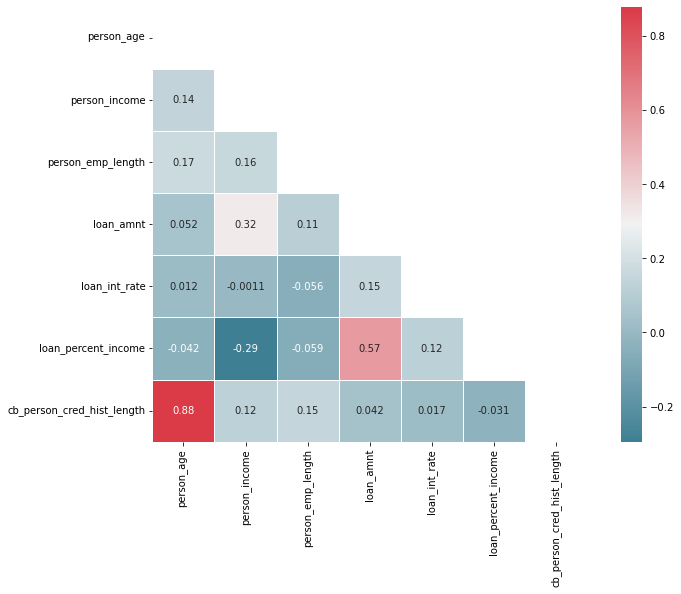

In [58]:
# gets the correlation between the numerical variables
correlation = num_attributes.corr(method='pearson')

# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(12, 8)

# generates a mask for the upper triangle
mask = np.triu(np.ones_like(correlation, dtype=np.bool))

# generates a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# plots the heatmap
sns.heatmap(correlation, cmap=cmap, mask=mask, square=True, linewidths=.5, annot=True)

# displays the plot
plt.show()

###  Correlations between categorical attributes (explanatory vars)

In [59]:
# creates a dataset for categorical attributes
cat_attributes = df_cr_loan.select_dtypes(exclude=['int64', 'float64'])

#### Using Cramer V

In [60]:
# gets the cramer list of calculated values
cramer_list = gu.get_cramer_list(cat_attributes)

# builds the dataset to make the correlations
cat_corr = pd.DataFrame({'person_home_ownership': cramer_list[0],
                  'loan_intent': cramer_list[1],
                  'loan_grade': cramer_list[2],
                  'cb_person_default_on_file': cramer_list[3]
                 })

# sets index equal to columns
cat_corr = cat_corr.set_index(cat_corr.columns)

NameError: name 'gu' is not defined

#### Using Theil's U

In [61]:
# gets the theils_u list of calculated values
theils_u_list = gu.get_theils_u_list(cat_attributes)

# builds the dataset to make the correlations
cat_corr_tu = pd.DataFrame({'person_home_ownership': theils_u_list[0],
                  'loan_intent': theils_u_list[1],
                  'loan_grade': theils_u_list[2],
                  'cb_person_default_on_file': theils_u_list[3]
                 })

# sets index equal to columns
cat_corr_tu = cat_corr_tu.set_index(cat_corr_tu.columns)

NameError: name 'gu' is not defined

#### Analyzing the correlation methods

NameError: name 'cat_corr' is not defined

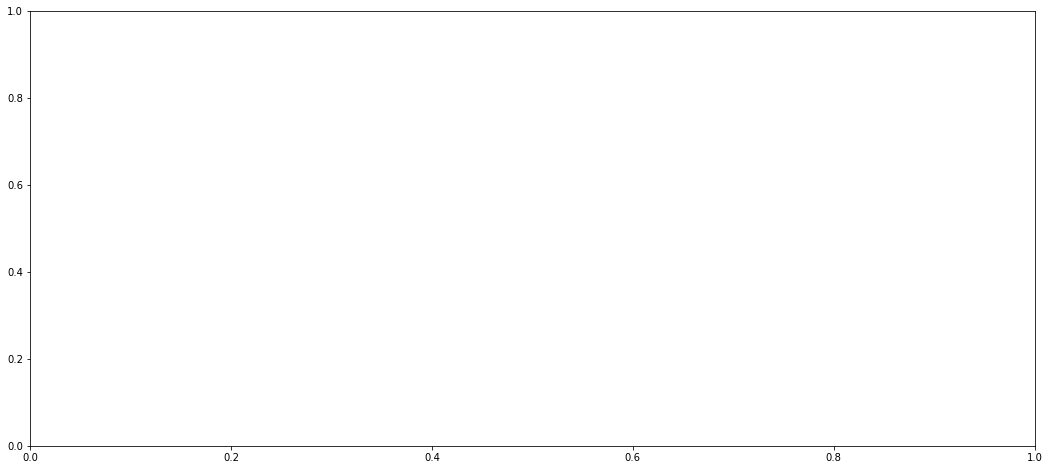

In [62]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(18, 8)

# generates a mask for the upper triangle
mask = np.triu(np.ones_like(cat_corr, dtype=np.bool))
mask = np.triu(np.ones_like(cat_corr_tu, dtype=np.bool))

# generates a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# plots the heatmap
plt.subplot(1,2,1)
sns.heatmap(cat_corr, cmap=cmap, mask=mask, square=True, linewidths=.5, annot=True, annot_kws={"size":14})
plt.title("Correlations using Cramer V", fontsize=14)

plt.subplot(1,2,2)
sns.heatmap(cat_corr_tu, cmap=cmap, mask=mask, square=True, linewidths=.5, annot=True, annot_kws={"size":14})
plt.title("Correlations using Theil's U", fontsize=14)

# adjusts vertical space between plots
plt.subplots_adjust(hspace = 0.3)
plt.subplots_adjust(wspace = 0.3)

# displays the plot
plt.show()

#  Data preprocessing

## Loading data set

In [65]:
# loads data set
df_cr_loan = pd.read_csv('/Users/aaryamehta/Desktop/CAPSTONE/credit_risk-master/data/cr_loan_clean.csv')
df_cr_loan.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
1,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
2,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
3,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4
4,21,9900,OWN,2.0,VENTURE,A,2500,7.14,1,0.25,N,2


In [66]:
# checks data size
df_cr_loan.shape

(29459, 12)

## Scaling numerical vars

In [67]:
# selects only numerical data types variables
df_numerical_vars = df_cr_loan.select_dtypes(include=['int64', 'float64']).drop('loan_status', axis=1)

In [68]:
# instantiates the scaler
mms = MinMaxScaler()

# applies the scaler
scaled_numerical = mms.fit_transform(df_numerical_vars)

# saves the rescaling
pickle.dump(mms, open('numerical_vars_scaler.pkl', 'wb'))

In [69]:
# gets the Data Frame version of numerical scaled for later manipulation
df_scaled_numerical = pd.DataFrame(scaled_numerical)

# renaming the columns of result Data Frame
df_scaled_numerical.columns = df_numerical_vars.columns

In [70]:
# checks data set size
df_scaled_numerical.shape

(29459, 7)

## Transformation

### Encoding categorical data

Once the new columns have been created using one-hot encoding, we can concatenate them with the numeric columns to create a new data frame which will be used throughout the rest of the course for predicting probability of default.

Remember to only one-hot encode the non-numeric columns. Doing this to the numeric columns would create an incredibly wide data set.

In [71]:
# creates data sets for non-numeric data
cred_str = df_cr_loan.select_dtypes(include=['object'])

# One-hot encode the non-numeric columns
cred_str_onehot = pd.get_dummies(cred_str)

# union the one-hot encoded columns to the numeric ones
df_cr_loan_prep = pd.concat([df_scaled_numerical, cred_str_onehot], axis=1)

# prints the columns in the new data set
print(df_cr_loan_prep.columns)

Index(['person_age', 'person_income', 'person_emp_length', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length',
       'person_home_ownership_MORTGAGE', 'person_home_ownership_OTHER',
       'person_home_ownership_OWN', 'person_home_ownership_RENT',
       'loan_intent_DEBTCONSOLIDATION', 'loan_intent_EDUCATION',
       'loan_intent_HOMEIMPROVEMENT', 'loan_intent_MEDICAL',
       'loan_intent_PERSONAL', 'loan_intent_VENTURE', 'loan_grade_A',
       'loan_grade_B', 'loan_grade_C', 'loan_grade_D', 'loan_grade_E',
       'loan_grade_F', 'loan_grade_G', 'cb_person_default_on_file_N',
       'cb_person_default_on_file_Y'],
      dtype='object')


##  Joining everything

In [72]:
# stores the loan status
loan_status = df_cr_loan[['loan_status']].copy()

In [73]:
# joins target and all explain vars
df_cr_loan_prep = pd.concat([loan_status, df_cr_loan_prep], axis=1)

In [74]:
# checks the data set info
df_cr_loan_prep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29459 entries, 0 to 29458
Data columns (total 27 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   loan_status                     29459 non-null  int64  
 1   person_age                      29459 non-null  float64
 2   person_income                   29459 non-null  float64
 3   person_emp_length               29459 non-null  float64
 4   loan_amnt                       29459 non-null  float64
 5   loan_int_rate                   29459 non-null  float64
 6   loan_percent_income             29459 non-null  float64
 7   cb_person_cred_hist_length      29459 non-null  float64
 8   person_home_ownership_MORTGAGE  29459 non-null  uint8  
 9   person_home_ownership_OTHER     29459 non-null  uint8  
 10  person_home_ownership_OWN       29459 non-null  uint8  
 11  person_home_ownership_RENT      29459 non-null  uint8  
 12  loan_intent_DEBTCONSOLIDATION   

##  Checkpoint

In [76]:
# saves data set state
df_cr_loan_prep.to_csv('/Users/aaryamehta/Desktop/CAPSTONE/credit_risk-master/data/cr_loan_prep.csv', index=False)

#  Machine Learning Modeling

### Targe variable: `loan_status` (`0` = non-default ; `1` = default)

##  Loading data set

In [79]:
# loads data set WITH Boruta selection
# df_cr_loan = pd.read_csv('data/cr_loan_to_ML.csv')

# loads data set WITHOUT Boruta selection
df_cr_loan = pd.read_csv('/Users/aaryamehta/Desktop/CAPSTONE/credit_risk-master/data/cr_loan_prep.csv')

# display data set info
df_cr_loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29459 entries, 0 to 29458
Data columns (total 27 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   loan_status                     29459 non-null  int64  
 1   person_age                      29459 non-null  float64
 2   person_income                   29459 non-null  float64
 3   person_emp_length               29459 non-null  float64
 4   loan_amnt                       29459 non-null  float64
 5   loan_int_rate                   29459 non-null  float64
 6   loan_percent_income             29459 non-null  float64
 7   cb_person_cred_hist_length      29459 non-null  float64
 8   person_home_ownership_MORTGAGE  29459 non-null  int64  
 9   person_home_ownership_OTHER     29459 non-null  int64  
 10  person_home_ownership_OWN       29459 non-null  int64  
 11  person_home_ownership_RENT      29459 non-null  int64  
 12  loan_intent_DEBTCONSOLIDATION   

##  Split data set into train and test

In [81]:
# creates the X and y data sets
X = df_cr_loan.drop('loan_status', axis=1).values
y = df_cr_loan['loan_status'].values

# splits into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, 
                                                        random_state= SEED, stratify=y)

NameError: name 'SEED' is not defined

##  Balancing data for training

Recommended reading: https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.combine.SMOTETomek.html#imblearn.combine.SMOTETomek

In [ ]:
# counts the number of classes before oversampling
print('Before balancing:', Counter(y_train))

# defines the resampler
resampler = SMOTETomek(random_state=SEED, n_jobs=-1)

# transforms the data set
X_balanced, y_balanced = resampler.fit_resample(X_train, y_train)

# counts the number of classes after oversampling
print('After balancing:', Counter(y_balanced))

In [ ]:
# plots before and after SMOTE
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
sns.countplot(x=y_train)
plt.title("Before SMOTE")

plt.subplot(1,2,2)
sns.countplot(x=y_balanced)
plt.title("After SMOTE")

plt.show()

In [ ]:
print("Total records BEFORE:", X_train.shape[0])
print("Total records AFTER:", X_balanced.shape[0])
print("Difference =", X_train.shape[0] - X_balanced.shape[0])

##  Training the models and getting the performance metrics

In [ ]:
# Set the threshold for defaults
THRESHOLD = 0.45

In [ ]:
# list os classifiers
classifiers = [LogisticRegression(max_iter=220, random_state=SEED),
               RandomForestClassifier(random_state=SEED),
               xgb.XGBClassifier(random_state=SEED),
               CatBoostClassifier(random_state=SEED, verbose=False)]

In [ ]:
# calculates classifiers performance
df_performances = gu.get_classifiers_performance(X_balanced, X_test, y_balanced, y_test, 
                                                 THRESHOLD, classifiers)
# highlight max values for each column
df_performances.style.highlight_max()

The <mark>**highlighted cells**</mark> correspond to the max value at each column.

As observed, for the context of our project, we are aiming for recall. `LogisticRegression` presents the highest recall score. However, it's precision score is the lowest. Let's assume we are aiming more for recall and moderate to precision, we could then, take advantage of f1-score, as it's the harmonic average between precision and recall. Thus, the algorithm that satisfies this need is `CatBoostClassifier`.

##  Confusion Matrix

In [ ]:
# sets suplots dimensions
n_rows = 2
n_cols = 2

# plots a confusion matrix for each classifier
gu.plot_multiple_confusion_matrices(n_rows, n_cols, X_test, y_test, classifiers, THRESHOLD)

##  Probability distribution

In [ ]:
# instantiates the classifiers
lr_clf = LogisticRegression(max_iter=220, random_state=SEED)
rf_clf = RandomForestClassifier(random_state=SEED)
xgb_clf = xgb.XGBClassifier(random_state=SEED)
catb_clf = CatBoostClassifier(random_state=SEED, verbose=False)


# trains the classifiers
lr_clf.fit(X_balanced, y_balanced)
rf_clf.fit(X_balanced, y_balanced)
xgb_clf.fit(X_balanced, y_balanced)
catb_clf.fit(X_balanced, y_balanced)


# store the predicted probabilities for class 1
y_pred_lr_prob = lr_clf.predict_proba(X_test)[:, 1]
y_pred_rf_prob = rf_clf.predict_proba(X_test)[:, 1]
y_pred_xgb_prob = xgb_clf.predict_proba(X_test)[:, 1]
y_pred_catb_prob = catb_clf.predict_proba(X_test)[:,1]

In [ ]:
# sets plot size
plt.figure(figsize=(10,6))

# plots
sns.kdeplot(y_pred_lr_prob, label='Logistic Regression')
sns.kdeplot(y_pred_rf_prob, label='Random Forest')
sns.kdeplot(y_pred_xgb_prob, label='XGBoost')
sns.kdeplot(y_pred_catb_prob, label='CatBoost')

# sets the plot features
plt.title("Probability Density Plot", fontsize=14)
plt.legend()

# displays the plot
plt.show()

As observed, in general all the algorithms presents most probabilities concentrated around `0`. However, `XGBoostClassifier` presents the largest amount of probabilities concentrated around `0` while `LogisticRegression` presenting the least with a moderate distributed probabilities around other values. `RandomForest` seems to be the mid-term between the other two, but its F1-Score precision score aren't satisfactory enough to consider it, as we compared with other algorithms. The mid-term between `XGBoost` and `RandomForest` is `CatBoost` which suits best for the context and challenge of our project.

In [ ]:
# set axes
fig, ax = plt.subplots()

# set fig size
ax.figure.set_size_inches(12, 8)

# plot probability - Logistic Regression
plt.subplot(2, 2, 1)
ax = stats.probplot(y_pred_lr_prob, plot=plt)

# plot probability - Random Forest
plt.subplot(2, 2, 2)
ax = stats.probplot(y_pred_rf_prob, plot=plt)

# plot probability - XGBoost
plt.subplot(2, 2, 3)
ax = stats.probplot(y_pred_xgb_prob, plot=plt)

# plot probability - CatBoost
plt.subplot(2, 2, 4)
ax = stats.probplot(y_pred_catb_prob, plot=plt)

plt.subplots_adjust(wspace=0.3)
plt.subplots_adjust(hspace=0.4)

# displays the plot
plt.show()

In [ ]:
# calculates the Brier Score Loss
bsl_lr = brier_score_loss(y_test, y_pred_lr_prob, pos_label=1)
bsl_rf = brier_score_loss(y_test, y_pred_rf_prob, pos_label=1)
bsl_xgb = brier_score_loss(y_test, y_pred_xgb_prob, pos_label=1)
bsl_catb = brier_score_loss(y_test, y_pred_catb_prob, pos_label=1)

# prints the calculated Brier Score Loss for each algorithm probability
print(f'Brier Score Loss (Logistic Regression): {bsl_lr}')
print(f'Brier Score Loss (Random Forest): {bsl_rf}')
print(f'Brier Score Loss (XGBoost): {bsl_xgb}')
print(f'Brier Score Loss (CatBoost): {bsl_catb}')

As observed, although the probability plots are quite similar, the Brier Score Loss are different. For this score, the closer to `0`, the better. Thus, `CatBoost` suits best for our needs.

##  Classification report

In [ ]:
# makes predictions
y_pred_lr= lr_clf.predict(X_test)
y_pred_rf= rf_clf.predict(X_test)
y_pred_xgb = xgb_clf.predict(X_test)
y_pred_catb = catb_clf.predict(X_test)

print('Classification Report for ' + type(lr_clf).__name__)
print(classification_report(y_test, y_pred_lr))

print('\nClassification Report for ' + type(rf_clf).__name__)
print(classification_report(y_test, y_pred_rf))

print('\nClassification Report for ' + type(xgb_clf).__name__)
print(classification_report(y_test, y_pred_xgb))

print('\nClassification Report for ' + type(catb_clf).__name__)
print(classification_report(y_test, y_pred_catb))

As we analyzed before, we're looking for high f1-score. Although `XGBoost` and `CatBoost` seems to have equal values for f1-score, looking at the precision score, `CatBoost` gives us a better result.

##  Cross-validation scoring - CatBoost Classifier

Now, we should use cross-validation scoring with `cross_val_score()` to check the overall performance.

In [ ]:
print(f'We have {X.shape[0]} records in the full data set.')

In [ ]:
print(f'Ratio of negatives in full data set: {pd.DataFrame(y)[0].value_counts(normalize=True).to_dict()[0]}')
print(f'Ratio of positives in full data set: {pd.DataFrame(y)[0].value_counts(normalize=True).to_dict()[1]}')

As observed, the original full data set is imbalanced, so we'll need to adopt the `StratifiedKFold` as our K-folding strategy for cross validation.

In [ ]:
# defines the cross validation strategy
cv = StratifiedKFold(n_splits=10)

In [ ]:
# calculates the cross validation scores
cv_scores = cross_val_score(catb_clf, X, np.ravel(y), cv = cv, scoring='precision', n_jobs=-1)

# prints the average precision and standard deviation of the scores
print("Average precision: %0.4f (+/- %0.4f)" % (cv_scores.mean(), cv_scores.std() * 2))


# calculates the cross validation scores
cv_scores = cross_val_score(catb_clf, X, np.ravel(y), cv = cv, scoring='recall', n_jobs=-1)

# prints the average recall and standard deviation of the scores
print("\nAverage recall: %0.4f (+/- %0.4f)" % (cv_scores.mean(), cv_scores.std() * 2))


# calculates the cross validation scores
cv_scores = cross_val_score(catb_clf, X, np.ravel(y), cv = cv, scoring='f1', n_jobs=-1)

# prints the average f1-score and standard deviation of the scores
print("\nAverage f1-score: %0.4f (+/- %0.4f)" % (cv_scores.mean(), cv_scores.std() * 2))


# calculates the cross validation scores
cv_scores = cross_val_score(catb_clf, X, np.ravel(y), cv = cv, scoring='roc_auc', n_jobs=-1)

# prints the average roc_auc and standard deviation of the scores
print("\nAverage ROC AUC: %0.4f (+/- %0.4f)" % (cv_scores.mean(), cv_scores.std() * 2))

#  Tuning Best Model

## CatBoost Classifier <font color="green"> (chosen as overall best)

##  Hyperparameter Tunning

In [ ]:
# instantiates the classifier
catb_clf = CatBoostClassifier(random_state=SEED, verbose=False)

In [ ]:
# set up space dictionary with specified hyperparameters
space = {'max_depth': np.arange(2, 10, 2),
         'min_data_in_leaf': [4, 8, 10],
         'learning_rate': np.linspace(0.001, 0.6, 15),
         'subsample': np.linspace(0.25, 1, 15),
         'n_estimators': np.arange(10, 105, 15)}

In [ ]:
# prepares RandomizedSearchCV object
catb_clf_cv = RandomizedSearchCV(estimator=catb_clf, param_distributions=space,
                                scoring='f1', n_iter=10, cv=5, verbose=2, 
                                random_state=SEED, n_jobs=-1)

In [ ]:
# fits the RandomizedSearchCV object
catb_clf_cv.fit(X_balanced, y_balanced)

In [ ]:
# best estimator
catb_clf_cv.best_estimator_

##  Predictions & Metrics

In [ ]:
# sets the threshold
THRESHOLD = 0.45

# extract the best estimator
catb_tuned_model = catb_clf_cv.best_estimator_

# calculates classifiers performance
df_performance = gu.get_classifiers_performance(X_balanced, X_test, 
                                                np.ravel(y_balanced), np.ravel(y_test), 
                                                THRESHOLD, [catb_tuned_model])

df_performance

In [ ]:
# Print the tuned parameters and score
print("\nTuned Parameters: {}".format(catb_clf_cv.best_params_)) 
print("\nBest score: {:.4f}".format(catb_clf_cv.best_score_))

##  ROC Curve

In [ ]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(10, 6)

# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]

# predict probabilities
catb_tuned_model_probs = catb_tuned_model.predict_proba(X_test)

# calculates the roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
catb_fpr, catb_tpr, _ = roc_curve(y_test, y_pred_catb_prob)
tuned_fpr, tuned_tpr, _ = roc_curve(y_test, catb_tuned_model_probs[:,1])

# plots the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(catb_fpr, catb_tpr, marker='.', label='CatBoost')
plt.plot(tuned_fpr, tuned_tpr, marker='.', label='CatBoost (Tunned HP)')

# sets plot features
plt.title("ROC Curve", fontsize=14)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# displays the legend
plt.legend()

# displays the plot
plt.show()

##  Confusion Matrix

In [ ]:
# keeps probabilities for the positive outcome only
df_probs = pd.DataFrame(catb_tuned_model_probs[:, 1], columns = ['prob_default'])

# applied the threshold
y_pred = df_probs['prob_default'].apply(lambda x: 1 if x > THRESHOLD else 0)

gu.plot_single_confusion_matrix(y_test, y_pred, catb_tuned_model, 'Tuned')

# displays plot
plt.show()

##  Cross-validation scoring

In [ ]:
# defines the cross validation strategy
cv = StratifiedKFold(n_splits=10)

In [ ]:
# calculates the cross validation scores
cv_scores = cross_val_score(catb_tuned_model, X, np.ravel(y), cv = cv, scoring='precision', n_jobs=-1)

# prints the average precision and standard deviation of the scores
print("Average precision: %0.4f (+/- %0.4f)" % (cv_scores.mean(), cv_scores.std() * 2))


# calculates the cross validation scores
cv_scores = cross_val_score(catb_tuned_model, X, np.ravel(y), cv = cv, scoring='recall', n_jobs=-1)

# prints the average recall and standard deviation of the scores
print("\nAverage recall: %0.4f (+/- %0.4f)" % (cv_scores.mean(), cv_scores.std() * 2))


# calculates the cross validation scores
cv_scores = cross_val_score(catb_tuned_model, X, np.ravel(y), cv = cv, scoring='f1', n_jobs=-1)

# prints the average f1-score and standard deviation of the scores
print("\nAverage f1-score: %0.4f (+/- %0.4f)" % (cv_scores.mean(), cv_scores.std() * 2))


# calculates the cross validation scores
cv_scores = cross_val_score(catb_tuned_model, X, np.ravel(y), cv = cv, scoring='roc_auc', n_jobs=-1)

# prints the average roc_auc and standard deviation of the scores
print("\nAverage ROC AUC: %0.4f (+/- %0.4f)" % (cv_scores.mean(), cv_scores.std() * 2))

## Saving the tuned model

In [ ]:
# saves the best model
pickle.dump(catb_tuned_model, open('model_credit_risk.pkl', 'wb'))

#  Tuned Model evaluation

## 10.1 Calibration curves

We need to check the calibration of two models (Calibrated and Non-Calibrated) to **see how stable the default prediction performance is across probabilities**. You can use a chart of each model's calibration to check this by calling the `calibration_curve()` function.

In [ ]:
# loads the tuned model
catb_tuned_model = pickle.load(open('model_credit_risk.pkl', 'rb'))

In [ ]:
# defines the cross validation strategy
cv = StratifiedKFold(n_splits=10)

In [ ]:
# trains the tuned model
catb_tuned_model.fit(X_balanced, y_balanced)

# defines and fits calibration model
calibrated_catb = CalibratedClassifierCV(catb_tuned_model, method='isotonic', cv=cv)
calibrated_catb.fit(X_train, y_train)

In [ ]:
# defines number of bins
BINS = 15

# predicts probabilities
catb_tuned_model_probs = catb_tuned_model.predict_proba(X_test)
calibrated_catb_probs = calibrated_catb.predict_proba(X_test)


# plots a calibration curve for each model
gu.plot_multiple_calibration_curves([calibrated_catb, catb_tuned_model], y_test, 
                                    [calibrated_catb_probs, catb_tuned_model_probs], BINS)

# displays the plot
plt.show()

In [ ]:
# calculates the Brier Score Loss
bsl_catb_model = brier_score_loss(y_test, catb_tuned_model_probs[:,1], pos_label=1)
bsl_catb_calibrated = brier_score_loss(y_test, calibrated_catb_probs[:,1], pos_label=1)

# prints the calculated the Brier Score Loss for each algorithm probability
print(f'Brier Score Loss (CatBoost Classifier (Tunned HP)): {bsl_catb_model}')
print(f'Brier Score Loss (CatBoost Classifier (Tunned HP + Calibrated)): {bsl_catb_calibrated}')

# checks which one has better calibration
if bsl_catb_calibrated < bsl_catb_model:
    print('\nCalibrated model has better calibration.')
else:
    print('\nUncalibrated model has better calibration.')

## Calibrated model metrics

In [ ]:
# sets the threshold
THRESHOLD = 0.45

# defines the classifiers list
classifiers = [calibrated_catb, catb_tuned_model]

# calculates classifiers performance
df_performance = gu.get_classifiers_performance(X_balanced, X_test, 
                                                np.ravel(y_balanced), np.ravel(y_test), 
                                                THRESHOLD, classifiers)

In [ ]:
# display the performance
df_performance.style.highlight_max(color='darkorange')

As observed, the calibrated model has a higher precision and f1-score.

##  Calibrated model - ROC Curve

In [ ]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(10, 6)

# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]

# calculates the roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
catb_fpr, catb_tpr, _ = roc_curve(y_test, catb_tuned_model_probs[:,1])
cal_fpr, cal_tpr, _ = roc_curve(y_test, calibrated_catb_probs[:,1])

# plots the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(catb_fpr, catb_tpr, marker='.', label='CatBoost (Tunned HP)')
plt.plot(cal_fpr, cal_tpr, marker='.', label='CatBoost (Tunned HP + Calibrated)')

# sets plot features
plt.title("ROC Curve", fontsize=14)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# displays the legend
plt.legend()

# displays the plot
plt.show()

##  Calibrated model - Confusion Matrix

In [ ]:
# defines the classifiers list
classifiers = [calibrated_catb, catb_tuned_model]

# plots the confusion matrices
gu.plot_multiple_confusion_matrices(1, 2, X_test, y_test, classifiers, THRESHOLD)

##  Calibrated model - cross validation-score

In [ ]:
# defines the cross validation strategy
cv = StratifiedKFold(n_splits=10)

In [ ]:
# calculates the cross validation scores
cv_scores = cross_val_score(calibrated_catb, X, np.ravel(y), cv = cv, scoring='precision', n_jobs=-1)

# prints the average precision and standard deviation of the scores
print("Average precision: %0.4f (+/- %0.4f)" % (cv_scores.mean(), cv_scores.std() * 2))


# calculates the cross validation scores
cv_scores = cross_val_score(calibrated_catb, X, np.ravel(y), cv = cv, scoring='recall', n_jobs=-1)

# prints the average recall and standard deviation of the scores
print("\nAverage recall: %0.4f (+/- %0.4f)" % (cv_scores.mean(), cv_scores.std() * 2))


# calculates the cross validation scores
cv_scores = cross_val_score(calibrated_catb, X, np.ravel(y), cv = cv, scoring='f1', n_jobs=-1)

# prints the average f1-score and standard deviation of the scores
print("\nAverage f1-score: %0.4f (+/- %0.4f)" % (cv_scores.mean(), cv_scores.std() * 2))


# calculates the cross validation scores
cv_scores = cross_val_score(calibrated_catb, X, np.ravel(y), cv = cv, scoring='roc_auc', n_jobs=-1)

# prints the average roc_auc and standard deviation of the scores
print("\nAverage ROC AUC: %0.4f (+/- %0.4f)" % (cv_scores.mean(), cv_scores.std() * 2))

##  Cross-validation summary

|                                                | Avg Precision             | Avg Recall                | f1\-score                 | Avg ROC AUC               |
|------------------------------------------------|---------------------------|---------------------------|---------------------------|---------------------------|
| CatBoost Classifier                            | 0\.8796 \(\+/\- 0\.1956\) | 0\.7190 \(\+/\- 0\.1793\) | 0\.7837 \(\+/\- 0\.0976\) | 0\.9041 \(\+/\- 0\.1005\) |
| CatBoost Classifier \(Tuned HP\)               | 0\.9101 \(\+/\- 0\.1554\) | 0\.7155 \(\+/\- 0\.1743\) | 0\.7947 \(\+/\- 0\.0823\) | 0\.9100 \(\+/\- 0\.0847\) |
| CatBoost Classifier \(Tuned HP \+ Calibrated\) | 0\.9625 \(\+/\- 0\.0693\) | 0\.7060 \(\+/\- 0\.1808\) | 0\.8100 \(\+/\- 0\.0959\) | 0\.9094 \(\+/\- 0\.0873\) |

As observed, although the CatBoost Classifier (Tunned HP) has a higher recall and ROC AUC, its probabilities aren't calibrated, so we're using the **CatBoost Classifier (Tuned HP + Calibrated)** in our web app because it's worth the trade-off between a little less precision, but a higher calibration quality. In addition, the Tuned HP + Claibrated model has a higher precision and f1-score.

##  Saving the calibrated model

In [ ]:
# saves the calibrated model
pickle.dump(calibrated_catb, open('model_credit_risk.pkl', 'wb'))

# Business performance

##  How thresholds affect performance

Now we can assess the financial impact using the default recall which is selected from the classification reporting using the function `precision_recall_fscore_support()`.

For this, we will estimate the amount of unexpected loss using the default recall to find what proportion of defaults we did **not** catch with the new threshold. This will be a dollar amount which tells us how much in losses we would have if all the unfound defaults were to default all at once.

In [ ]:
# converts X_test to Data Frame
df_aux = pd.DataFrame(X_test).loc[:,0:6]

# scales the data back
df_aux_scaled_back = pd.DataFrame(mms.inverse_transform(df_aux))

# assigns the cols names
df_aux_scaled_back.columns = df_numerical_vars.columns

# displays the data
df_aux_scaled_back

In [ ]:
# sets the average loan value
avg_loan_amnt = df_aux_scaled_back['loan_amnt'].mean()

# sets the threshold
THRESHOLD = 0.5

# reassigns the values of loan status based on the new threshold
df_probs['loan_status'] = df_probs['prob_default'].apply(lambda x: 1 if x > THRESHOLD else 0)

# stores the number of loan defaults from the prediction data
num_defaults = df_probs['loan_status'].value_counts()[1]

# stores the default recall from the classification report
default_recall = precision_recall_fscore_support(y_test, df_probs['loan_status'])[1][1]

# calculates the estimated impact of the new default recall rate
print(num_defaults * avg_loan_amnt * (1 - default_recall))

By our estimates, this loss would be around `$3.3` million dollars.

## Acceptance rates

In [ ]:
# defines probabilities Data Frame
df_probs = pd.DataFrame(calibrated_catb_probs[:,1])
df_probs.columns = ['prob_default']

In [ ]:
# prepares a Data Frame of labels and pred probability
test_pred_df = pd.concat([pd.DataFrame(y_test).reset_index(), df_probs], axis=1)
test_pred_df.drop('index', axis=1, inplace=True)

test_pred_df.columns = ['y_true','prob_default']
test_pred_df

In [ ]:
# checks the statistics of the probabilities of default
print(test_pred_df['prob_default'].describe())

 In the results of `.describe()` do you see how it's not until `75%` that we start to see double-digit numbers? That's because the majority of our test set is non-default loans. Next let's look at how the acceptance rate and threshold split up the data.

In [ ]:
# calculates the threshold for a 85% acceptance rate
threshold_85 = np.quantile(test_pred_df['prob_default'], .85)

# applies acceptance rate threshold
test_pred_df['pred_loan_status'] = test_pred_df['prob_default'].apply(lambda x: 1 if x > threshold_85 else 0)

# prints the counts of loan status after the threshold
print(test_pred_df['pred_loan_status'].value_counts())

## Visualizing quantiles of acceptance

In [ ]:
# sets plot size
plt.figure(figsize=(8, 6))

# plots the predicted probabilities of default
plt.hist(calibrated_catb_probs[:,1], color = 'b', bins = 40)
# plt.hist(stack_clf_probs[:,1], color = 'blue', bins = 40)

# calculates the threshold with quantile
threshold = np.quantile(calibrated_catb_probs[:,1], .85)

# adds a reference line to the plot for the threshold
plt.axvline(x = threshold, color = 'r', label="Threshold")

# sets plot features
plt.xlabel("Probabilities of default")
plt.ylabel("Count")
plt.title("Predicted probabilities of default histogram", fontsize=14)
plt.legend()

# displays the plot
plt.show()

Here, we can see where the threshold is on the range of predicted probabilities. Not only can we see how many loans will be accepted (left side), but also how many loans will be rejected (right side). 

We can re-run this code with different threshold values to better understand how this affects the acceptance rate.

## Bad rates

In [ ]:
# renames columns
test_pred_df.columns = ['true_loan_status', 'prob_default', 'pred_loan_status']

In [ ]:
# Print the top 5 rows of the new data frame
test_pred_df.head()

In [ ]:
# creates a subset of only accepted loans
accepted_loans = test_pred_df[test_pred_df['pred_loan_status'] == 0]

# calculates the bad rate
print(np.sum(accepted_loans['true_loan_status']) / accepted_loans['true_loan_status'].count())

##  Acceptance rate impact

In [ ]:
df_aux_scaled_back

In [ ]:
# prepares the Data Frame
test_pred_df2 = pd.concat([test_pred_df, df_aux_scaled_back[['loan_amnt']].reset_index()], axis=1)
test_pred_df2.drop('index', axis=1, inplace=True)
test_pred_df2

In [ ]:
# prints the statistics of the loan amount column
print(test_pred_df2['loan_amnt'].describe())

In [ ]:
# stores the average loan amount
avg_loan = np.mean(test_pred_df2['loan_amnt'])

# sets the formatting for currency, and prints the cross tab
pd.options.display.float_format = '${:,.2f}'.format
print(pd.crosstab(test_pred_df2['true_loan_status'],
                 test_pred_df2['pred_loan_status']).apply(lambda x: x * avg_loan, axis = 0))

With this, we can see that our bad rate of about `8.3%` (`[1,0]`) represents an estimated loan value of about **5.0 million dollars**. This may seem like a lot at first, but compare it to the total value of non-default loans (`[0,0]`)! With this, we are ready to start talking about our acceptance strategy going forward.

## Making the strategy table

In [ ]:
# sets the acceptance rates
accept_rates = np.linspace(1.0, 0.05, 20)

# sets the vars
thresholds = []
bad_rates = []

In [ ]:
# populates the arrays for the strategy table with a for loop
for rate in accept_rates:
    # calculates the threshold for the acceptance rate
    curr_thresh = np.quantile(df_probs['prob_default'], rate).round(4)
    
    # adds the threshold value to the list of thresholds
    thresholds.append(curr_thresh)
    
    # reassigns the loan_status value using the threshold
    test_pred_df['pred_loan_status'] = test_pred_df['prob_default'].apply(lambda x: 1 if x > curr_thresh else 0)
    
    # creates a set of accepted loans using this acceptance rate
    accepted_loans = test_pred_df[test_pred_df['pred_loan_status'] == 0]
    
    # calculates and append the bad rate using the acceptance rate
    curr_bad_rate = np.sum((accepted_loans['true_loan_status']) / len(accepted_loans['true_loan_status'])).round(4)
    bad_rates.append(curr_bad_rate)

In [ ]:
# sets format to suppress scientific notation
pd.options.display.float_format = '{:,.4f}'.format

# creates a data frame of the strategy table
strat_df = pd.DataFrame(zip(accept_rates, thresholds, bad_rates),
                        columns = ['Acceptance Rate','Threshold','Bad Rate'])

# Print the entire table
strat_df

##  Visualizing the strategy

Now we have the extended strategy table `strat_df`. The table is not so big that it's difficult to analyze, but visuals can help we see the overview all at once.

We should check at the distribution of each column with a box plot. **If the distribution of Acceptance Rate looks the same as the Bad Rate column, that could be a problem. That means that the model's calibration is likely much worse than we thought.**

We can also visualize the strategy curve with a line plot. **The Acceptance Rate would be the independent variable with the Bad Rate as the dependent variable.**

In [ ]:
# visualizes the distributions in the strategy table with a boxplot
plt.figure(figsize=(8,8))
strat_df.boxplot()
plt.show()

In [ ]:
# sets plot size
plt.figure(figsize=(8,8))

# plots the strategy curve
plt.plot(strat_df['Acceptance Rate'], strat_df['Bad Rate'])

# sets plot features
plt.xlabel('Acceptance Rate')
plt.ylabel('Bad Rate')
plt.title('Acceptance and Bad Rates', fontsize=14)

# displays the plot
plt.show()

 The boxplot shows us the distribution for each column. Look at the strategy curve. The bad rates are very low up until the acceptance rate `0.6` where they suddenly increase. This suggests that many of the accepted defaults may have a `prob_default` value between `0.6` and `0.8`.

##  Estimated value profiling

In [ ]:
# overwrites the data set
test_pred_df = test_pred_df2.copy()

In [ ]:
# sets the acceptance rates
accept_rates = [1.0, 0.95, 0.9, 0.85, 0.8, 0.75, 0.7, 0.65, 0.6, 0.55, 
                0.5, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05]

# sets the vars
thresholds = []
bad_rates = []
num_accepted_loans = []
avg_loan_amnt = []

In [ ]:
# populates the arrays for the strategy table with a for loop
for rate in accept_rates:
    # calculates the threshold for the acceptance rate
    curr_thresh = np.quantile(df_probs['prob_default'], rate).round(4)
    
    # adds the threshold value to the list of thresholds
    thresholds.append(curr_thresh)
    
    # reassigns the loan_status value using the threshold
    test_pred_df['pred_loan_status'] = test_pred_df['prob_default'].apply(lambda x: 1 if x > curr_thresh else 0)
    
    # creates a set of accepted loans using this acceptance rate
    accepted_loans = test_pred_df[test_pred_df['pred_loan_status'] == 0]
    
    # calculates and appends the bad rate using the acceptance rate
    curr_bad_rate = np.sum((accepted_loans['true_loan_status']) / len(accepted_loans['true_loan_status'])).round(4)
    bad_rates.append(curr_bad_rate)
    
    # calculates and appends the number of accepted loans using the acceptance rate
    curr_num_acc_loans = len(test_pred_df[test_pred_df['prob_default'] < np.quantile(test_pred_df['prob_default'], rate)])
    num_accepted_loans.append(curr_num_acc_loans)
    
    # calculates the avg loan amount
    avg_loan_amnt.append(np.mean(test_pred_df['loan_amnt']))

In [ ]:
# sets format to suppress scientific notation
pd.options.display.float_format = '{:,.4f}'.format

# creates a data frame of the strategy table
strat_df = pd.DataFrame(zip(accept_rates, thresholds, bad_rates, num_accepted_loans, avg_loan_amnt),
                        columns = ['Acceptance Rate','Threshold','Bad Rate', 
                                   'Num Accepted Loans', 'Avg Loan Amnt'])

# calculates the portfolio estimated values 
estimated_value = ((strat_df['Num Accepted Loans'] * (1 - strat_df['Bad Rate'])) * strat_df['Avg Loan Amnt']) - (strat_df['Num Accepted Loans'] * strat_df['Bad Rate'] * strat_df['Avg Loan Amnt'])

# includes the column for the estimated_value
strat_df = pd.DataFrame(zip(accept_rates, thresholds, bad_rates, 
                            num_accepted_loans, avg_loan_amnt, estimated_value),
                        columns = ['Acceptance Rate','Threshold','Bad Rate', 
                                   'Num Accepted Loans', 'Avg Loan Amnt', 'Estimated Value'])

# prints the entire table
strat_df.style.highlight_max(subset='Estimated Value')

| Column |	Description|
|:-------|:------------|
| Num Accepted Loans |	The number of accepted loans based on the threshold|
| Avg Loan Amnt 	|The average loan amount of the entire test set|
| Estimated value |	The estimated net value of non-defaults minus defaults|

The highlighted cell indicates the **<mark>Max Est. Value</mark>** for the current portfolio.

In [ ]:
# sets plot size
plt.figure(figsize=(10,8))

# creates a line plot of estimated value
plt.plot(strat_df['Acceptance Rate'], strat_df['Estimated Value'])

# adds a reference line to the plot for the threshold
plt.axvline(x = 0.85, color = 'red', linestyle=":", label="Acceptance Rate for Maximum Estimated Value")

# sets plot feaures
plt.title('Estimated Value by Acceptance Rate', fontsize=14)
plt.xlabel('Acceptance Rate')
plt.ylabel('Estimated Value')
plt.legend()

# displays the plot
plt.show()

In [ ]:
# prints the row with the max estimated value
strat_df.loc[strat_df['Estimated Value'] == np.max(strat_df['Estimated Value'])]

With our credit data and our estimated averag loan value, we clearly see that the acceptance rate `0.85` has the highest potential estimated value. Normally, the allowable bad rate is set, but we can use analyses like this to explore other options.

##  Total expected loss

### $Total\ Expected\ Loss = \sum_{x=1}^n PD_x * LGD_x * EAD_x.$

### `expected_loss = prob_default * lgd * loan_amnt`

We'll assume that the exposure is the full value of the loan, and the **loss given default is 100%**. This means that **a default on each loan is a loss of the entire amount**.

In [ ]:
# loss given default is 100%
test_pred_df['loss_given_default'] = 1.0

In [ ]:
# prints the first five rows of the data frame
test_pred_df.head()

In [ ]:
# calculates the bank's expected loss and assign it to a new column
test_pred_df['expected_loss'] = test_pred_df['prob_default'] * test_pred_df['loss_given_default'] * test_pred_df['loan_amnt']

# calculates the total expected loss to two decimal places
tot_exp_loss = round(np.sum(test_pred_df['expected_loss']), 2)

# prints the total expected loss
print('Total expected loss: ', '${:,.2f}'.format(tot_exp_loss))

```
Total expected loss:  $19,596,497.74
```

| Used algorithm                    | Calibrated? | Boruta? | Algorithm that was used by Boruta | Number of remaining features | Total expected loss |
|-----------------------------------|-------------|---------|-----------------------------------|------------------------------|---------------------|
| No algorithm, just human guessing | N/A         | N/A     | N/A                               | 26                           | 35,395,287\.50    |
| XGBoost Classifier                | No          | Yes     | Random Forest Classifier          | 7                            | 29,276,107\.72    |
| XGBoost Classifier                | Yes         | Yes     | Random Forest Classifier          | 7                            | 28,948,507\.08    |
| XGBoost Classifier                | Yes         | Yes     | XGBoost Classifier                | 19                           | 27,821,760\.79    |
| XGBoost Classifier                | Yes         | No      | N/A                               | 26                           | 19,596,497\.74    |
| Stacking Classifier XGB           | Yes         | No      | N/A                               | 26                           | 20,431,941\.38    |
| CatBoost Classifier \(HP\)        | Yes         | No      | N/A                               | 26                           | 17,547,088\.71      |


## Making the Pipeline

In [ ]:
# data manipulation
import pickle
import pandas as pd
import numpy as np

# data transformation
from sklearn.preprocessing import MinMaxScaler


class Pipeline(object):

    def __init__(self):
        # sets the home path
        self.home_path = ''

        # loads model
        self.model = pickle.load(
            open(self.home_path + 'model_credit_risk.pkl', 'rb'))

        # instantiates the scaler
        self.scaler = pickle.load(
            open(self.home_path + 'numerical_vars_scaler.pkl', 'rb'))

    # scales and encodes the data
    def transform(self, input_data):
        data = input_data.copy()

        ##########################
        # SCALING NUMERICAL VARS #
        ##########################

        # selects only numerical data types variables
        df_numerical_vars = data.select_dtypes(
            include=['int64', 'float64']).drop('loan_status', axis=1)

        # applies the scaler
        scaled_numerical = self.scaler.transform(df_numerical_vars)

        # gets the Data Frame version of numerical scaled for later manipulation
        df_scaled_numerical = pd.DataFrame(scaled_numerical)

        # renaming the columns of result Data Frame
        df_scaled_numerical.columns = df_numerical_vars.columns

        #############################
        # ENCODING CATEGORICAL VARS #
        #############################

        # creates data sets for non-numeric data
        cred_str = data.select_dtypes(include=['object'])

        # One-hot encode the non-numeric columns
        cred_str_onehot = pd.get_dummies(cred_str)

        # union the one-hot encoded columns to the numeric ones
        df_cr_loan_prep = pd.concat(
            [df_scaled_numerical, cred_str_onehot], axis=1)

        return df_cr_loan_prep

    def predict(self, input_data):
        transformed_data = self.transform(input_data)

        predictions = self.model.predict_proba(transformed_data)

        return predictions


In [ ]:
def prepare_data_for_calculation(data_frame, probs):

    # defines probabilities Data Frame
    df_probs = pd.DataFrame(probs[:, 1])
    df_probs.columns = ['prob_default']

    # concatenates the probabilities with the respective loan amount
    df_prep = pd.concat(
        [df_probs, data_frame[['loan_amnt']].reset_index()], axis=1)

    # drops unused column
    df_prep.drop('index', axis=1, inplace=True)

    return df_prep


def calculate_total_expected_loss(data_frame, probs, lgd, ead):

    # calls the function to prepare the Data Frame
    data = prepare_data_for_calculation(data_frame, probs)

    # sets the loss given default
    data['loss_given_default'] = lgd

    # calculates the bank's expected loss and assign it to a new column
    data['expected_loss'] = data['prob_default'] * \
        data['loss_given_default'] * (data['loan_amnt'] * ead)

    # calculates the total expected loss to two decimal places
    total_exp_loss = round(np.sum(data['expected_loss']), 2)

    return total_exp_loss

##  Sampling the data for test

In [ ]:
# loads data set
df_raw = pd.read_csv('data/cr_loan_clean.csv')

# selects a sample
df_raw = df_raw.sample(n=10000, random_state=SEED)

# exports the test data set
df_raw.to_csv('data/test_data.csv', index=False)

df_raw.head()

In [ ]:
df_raw.shape

##  Testing the Pipeline

In [ ]:
# instantiate the data pipeline
pipeline = Pipeline()

# makes the predictions
predictions = pipeline.predict(df_raw)

# calculates the total expected_loss
LGD = 1
EAD = 1

total_expected_loss = calculate_total_expected_loss(df_raw, predictions, LGD, EAD)

print(f'${total_expected_loss:,.2f}')